In [18]:
import numpy as np
import  random  
import matplotlib.pyplot as plt
from sklearn.externals.joblib import Memory
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

def get_data(path,feature):
    data = load_svmlight_file(path,feature)    
    return data

def predict(W , X, y ,threshold):
    z= np.dot(W.T ,X)
    temp= 1./(1+np.exp( -z))
    y_pred=np.zeros(temp.shape)
    y_pred[temp> threshold]=1;
    y_pred[temp<=threshold]=0;
    cmp=y_pred==y
    accuracy=len(cmp[cmp==True])/y.shape[1]
    return y_pred,accuracy 

In [19]:
# 读取数据
data = get_data(path="a9a",feature=123)

# 数据预处理
x_train=data[0].toarray()
x_train=np.column_stack((x_train,np.ones([x_train.shape[0],1])))
x_train=x_train.T
y_train=data[1]
y_train=y_train.reshape(1,len(y_train)) 
y_train=y_train.astype(np.int)
y_train[y_train== -1]=0
D_in, N =x_train.shape
D_out = y_train.shape[0]

# 读取数据
data = get_data(path="a9a.t",feature=123)

# 数据预处理
x_test=data[0].toarray()
x_test=np.column_stack((x_test,np.ones([x_test.shape[0],1])))
x_test=x_test.T
y_test=data[1]
y_test=y_test.reshape(1,len(y_test)) 
y_test=y_test.astype(np.int)
y_test[y_test== -1]=0

In [20]:
# 参数初始化
maxIterations=10000 # 迭代
eta = 0.05 # 学习率
threshold=0.5 # 大于阈值的标记为正类，反之为负类

In [21]:
def logisticRegression(W ,xtrain, ytrain, xtest ,ytest):
    N = xtrain.shape[1]
    gradNum=10
    ind=random.sample(range(0,N),gradNum)  
    xtrain_batch=xtrain[:,ind]
    ytrain_batch=ytrain[:,ind]

    train_loss = 0
    test_loss =0
    
    dW = np.zeros(W.shape)  
    z_train= np.dot(W.T ,xtrain)
    a_train= 1./(1+np.exp( -z_train))
    a_train_batch=a_train[:,ind]
    z_test= np.dot(W.T ,xtest)
    a_test= 1./(1+np.exp( -z_test))

    #逻辑回归Loss
    train_loss= -1/N *(np.dot(np.log(a_train),ytrain.T)+np.dot(np.log(1.0-a_train),(1-ytrain).T))
    test_loss=-1/N *(np.dot(np.log(a_test),ytest.T)+np.dot(np.log(1.0-a_test),(1-ytest).T))

    #loss
    dz = a_train_batch-ytrain_batch
    dW = 1/N * np.dot(xtrain_batch, dz.T)

    return train_loss, test_loss, dW

In [22]:
# NAG
# 参数初始化   
W = np.zeros((D_in, D_out)) # weights
pre_d = np.zeros_like(W)
pre_grad = np.zeros_like(W)
gamma =0.9 #动量因子
L_NAG =[]; # 验证loss
for t in range(maxIterations):
    
    # 计算loss
    train_loss,test_loss ,grad =logisticRegression(W, x_train, y_train, x_test, y_test)
    
    # 保存
    L_NAG.append ( test_loss)
    
    # 更新weight
    d  = gamma * pre_d  + grad + gamma * (grad - pre_grad)
    dW = -eta * d
    W += dW 
    pre_d = d
    pre_grad = grad
    
L_NAG=np.array(L_NAG)
L_NAG=L_NAG[:,:,0]
y_pred_NAG_train,training_accuracy_NAG =predict(W , x_train, y_train ,threshold)
y_pred_NAG_test,test_accuracy_NAG=predict(W , x_test, y_test ,threshold)

In [23]:
# RMSProp 
# 参数初始化 
W = np.zeros((D_in, D_out)) # weights
n = np.zeros((D_in,D_out))
gamma =0.9 # 衰退因子 
epsilon = 0.001
L_RMSProp =[]  # 验证loss

for t in range(maxIterations):

    train_loss,test_loss ,grad =logisticRegression(W, x_train, y_train, x_test, y_test)
    
    L_RMSProp.append ( test_loss)

    n = gamma * n + (1-gamma) * np.power(grad,2)
    dW = -eta /np.sqrt(n + epsilon ) * grad
    W += dW 
    
L_RMSProp=np.array(L_RMSProp)
L_RMSProp=L_RMSProp[:,:,0]
y_pred_RMSProp_train,training_accuracy_RMSProp =predict(W , x_train, y_train ,threshold)
y_pred_RMSProp_test,test_accuracy_RMSProp =predict(W , x_test, y_test ,threshold)

In [24]:
# AdaDelta 
# 参数初始化
W = np.zeros((D_in, D_out)) # weights
E_g2 = np.zeros_like(W)
E_dW2 = np.zeros_like(W)
gamma =0.9 # 衰退因子
epsilon = 1e-3
L_AdaDelta =[]  # 验证loss

for t in range(maxIterations):

    train_loss,test_loss ,grad =logisticRegression(W, x_train, y_train, x_test, y_test)

    L_AdaDelta.append ( test_loss)
    
    E_g2 = gamma * E_g2 + (1-gamma) * np.power(grad,2)
    dW = - np.sqrt(E_dW2+epsilon) / np.sqrt(E_g2+epsilon) * grad    
    W += dW 
    E_dW2 = gamma * E_dW2 + (1-gamma) * np.power(dW , 2)
    
L_AdaDelta=np.array(L_AdaDelta)
L_AdaDelta=L_AdaDelta[:,:,0]
y_pred_AdaDelta_train,training_accuracy_AdaDelta =predict(W , x_train, y_train ,threshold)
y_pred_AdaDelta_test,test_accuracy_AdaDelta =predict(W , x_test, y_test ,threshold)

In [25]:
# Adam
# 参数初始化  
W = np.zeros((D_in, D_out)) # weights
n = np.zeros_like(W)
m = np.zeros_like(W)
mu = 0.9 # m的衰退因子
v = 0.9 # n的衰退因子 
epsilon = 1e-3
L_adam=[]  # 验证loss

for t in range(maxIterations):

    train_loss,test_loss ,grad =logisticRegression(W, x_train, y_train, x_test, y_test)

    L_adam.append ( test_loss)
    
    # 梯度估计
    m = mu * m + (1-mu) * grad
    n = v  * n + (1-v) * np.power(grad,2)
    
    m_hat = m / (1-np.power(mu,t)+epsilon) 
    n_hat = n / (1-np.power(v,t)+epsilon)
    W -= m_hat * eta /(np.sqrt(n_hat) + epsilon)
    
L_adam=np.array(L_adam)
L_adam=L_adam[:,:,0]
y_pred_Adam_train,training_accuracy_Adam =predict(W , x_train, y_train ,threshold)
y_pred_Adam_test,test_accuracy_Adam =predict(W , x_test, y_test ,threshold)

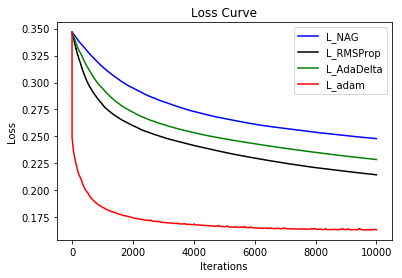

In [40]:
# 制图
plt.plot(L_NAG,'blue',label='L_NAG')
plt.plot(L_RMSProp,'black',label='L_RMSProp')
plt.plot(L_AdaDelta,'green',label='L_AdaDelta')
plt.plot(L_adam,'red',label='L_adam')
plt.title('Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [41]:
# 评估和预测结果
print('training accuracy_NAG=',training_accuracy_NAG,
      '\ntraining accuracy_RMSProp=',training_accuracy_RMSProp,
      '\ntraining accuracy_AdaDelta=',training_accuracy_AdaDelta,
      '\ntraining accuracy_Adam=',training_accuracy_Adam)

print('\ntest accuracy_NAG=',test_accuracy_NAG,
      '\ntest accuracy_RMSProp=',test_accuracy_RMSProp,
      '\ntest accuracy_AdaDelta=',test_accuracy_AdaDelta,
      '\ntest accuracy_Adam=',test_accuracy_Adam)

training accuracy_NAG= 0.7591904425539756 
training accuracy_RMSProp= 0.7850188876263015 
training accuracy_AdaDelta= 0.7623230244771352 
training accuracy_Adam= 0.8453671570283467

test accuracy_NAG= 0.7637737239727289 
test accuracy_RMSProp= 0.7890792948836066 
test accuracy_AdaDelta= 0.7662305755174743 
test accuracy_Adam= 0.8497635280388183


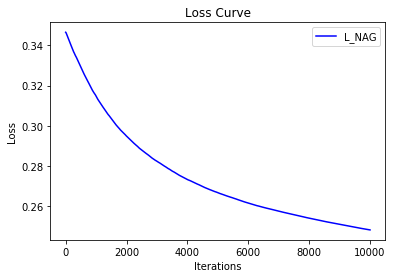

In [42]:
plt.plot(L_NAG,'blue',label='L_NAG')

plt.title('Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

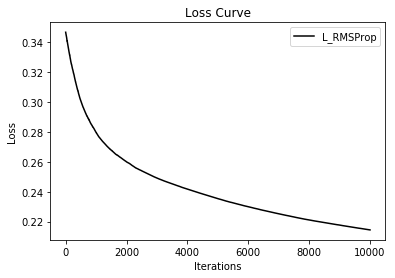

In [43]:
plt.plot(L_RMSProp,'black',label='L_RMSProp')

plt.title('Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

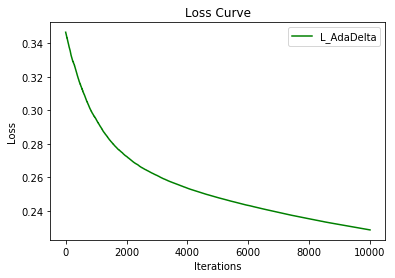

In [44]:
plt.plot(L_AdaDelta,'green',label='L_AdaDelta')

plt.title('Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

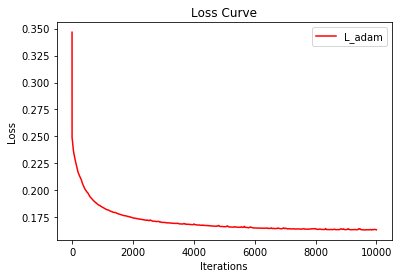

In [45]:
plt.plot(L_adam,'red',label='L_adam')

plt.title('Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()